## Simulate 4 place cells and 96 "random cells" (aka noise)

Code to simulate 4 place cells on a linear track, 2 of them having their place fields overlapping with the place field of the other two place cells. 

Add 96 cells that seem to fire randomly (their activity is independent from spatial location)

In [17]:
# 0. Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

### Part 1: Simulate place cells

In [ ]:
# 1. Set up functions to simulate neural activity and natural movement along a linear track

# Simulation parameters
track_length = 1.0  # meters
dt = 0.001  # time step (s) -> 100 Hz sampling
T = 300.0  # total time (s) -> 5 minutes
n_steps = int(T / dt)
time = np.arange(n_steps) * dt

# Velocity OU (Ornstein–Uhlenbeck) process parameters (produce smoothly varying speed & direction)
theta = 1.0   # mean reversion
mu = 0.0      # long-run mean velocity (m/s)
sigma = 0.4   # volatility of velocity (m/s * sqrt(s))
v0 = 0.0      # initial velocity

# Initialize arrays
pos = np.zeros(n_steps)
vel = np.zeros(n_steps)
pos[0] = 0.5  # start in middle
vel[0] = v0

rng = np.random.default_rng(42)

# simulate velocity (OU) and integrate to position with reflecting boundaries
for t in range(n_steps - 1):
    vel[t+1] = vel[t] + theta * (mu - vel[t]) * dt + sigma * np.sqrt(dt) * rng.standard_normal()
    pos[t+1] = pos[t] + vel[t+1] * dt
    # reflect at boundaries
    if pos[t+1] < 0:
        pos[t+1] = -pos[t+1]
        vel[t+1] = -vel[t+1]
    elif pos[t+1] > track_length:
        pos[t+1] = 2*track_length - pos[t+1]
        vel[t+1] = -vel[t+1]

In [8]:
# 2. Simulate 4 place cells with Gaussian tuning curves, with place cells C and D with a place field within the place field of A and B
# simulating recordings combining ventral to dorsal hippocampus (larger to smaller place fields)

centers = np.array([0.20, 0.30, 0.80, 0.90])  # meters
sigma_pf = np.array([0.2, 0.1, 0.2, 0.1])  # place field width (m)
peak_rates = np.array([20.0, 16.0, 18.0, 15.0])  # peak firing rates (Hz)
baseline_rate = 0.1  # baseline (Hz)


n_neurons = len(centers)
rates = np.zeros((n_neurons, n_steps))
for i in range(n_neurons):
    rates[i] = baseline_rate + peak_rates[i] * np.exp(-0.5 * ((pos - centers[i]) / sigma_pf[i])**2)

# Generate spikes: Bernoulli approximation for inhomogeneous Poisson
rng = np.random.default_rng(123)  # new rng for spikes
spikes = rng.random(size=(n_neurons, n_steps)) < (rates * dt)

# Extract spike times and positions
spike_times = [time[spikes[i]] for i in range(n_neurons)]
spike_positions = [pos[spikes[i]] for i in range(n_neurons)]
spike_counts = np.sum(spikes, axis=1)

# Empirical rate maps (bins)
n_bins = 50
bins = np.linspace(0, track_length, n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
occupancy, _ = np.histogram(pos, bins=bins)
occupancy_time = occupancy * dt
empirical_rate_maps = np.zeros((n_neurons, n_bins))
for i in range(n_neurons):
    sc, _ = np.histogram(spike_positions[i], bins=bins)
    with np.errstate(divide='ignore', invalid='ignore'):
        empirical_rate_maps[i] = np.where(occupancy_time > 0, sc / occupancy_time, 0.0)

# Theoretical rate over continuous x (for plotting)
x = np.linspace(0, track_length, 500)
theoretical_rates = np.zeros((n_neurons, x.size))
for i in range(n_neurons):
    theoretical_rates[i] = baseline_rate + peak_rates[i] * np.exp(-0.5 * ((x - centers[i]) / sigma_pf[i])**2)

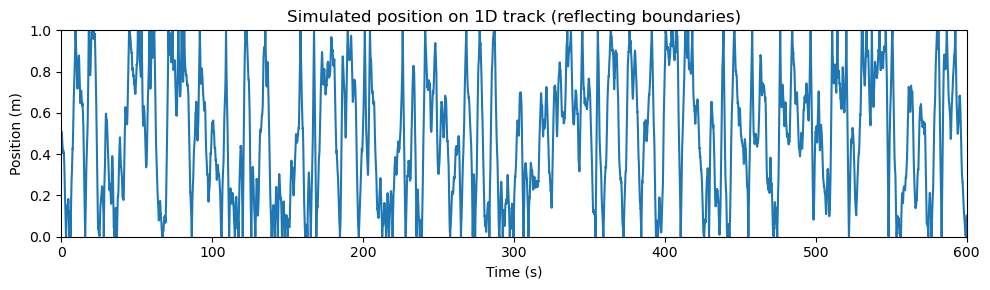

In [9]:

# ---------------- PLOTS ----------------
plt.figure(figsize=(10, 3))
plt.plot(time, pos)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Simulated position on 1D track (reflecting boundaries)')
plt.xlim(0, T)
plt.ylim(0, track_length)
plt.tight_layout()
plt.show()


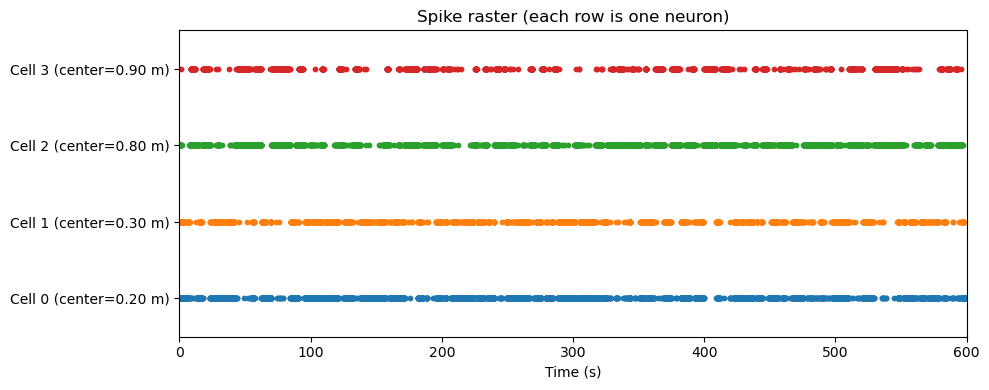

In [10]:
# Spike raster
plt.figure(figsize=(10, 2 + 0.5 * n_neurons))
for i in range(n_neurons):
    plt.scatter(spike_times[i], np.ones_like(spike_times[i]) * i, s=10)
plt.yticks(np.arange(n_neurons), [f'Cell {i} (center={centers[i]:.2f} m)' for i in range(n_neurons)])
plt.xlabel('Time (s)')
plt.title('Spike raster (each row is one neuron)')
plt.ylim(-0.5, n_neurons - 0.5)
plt.xlim(0, T)
plt.tight_layout()
plt.show()


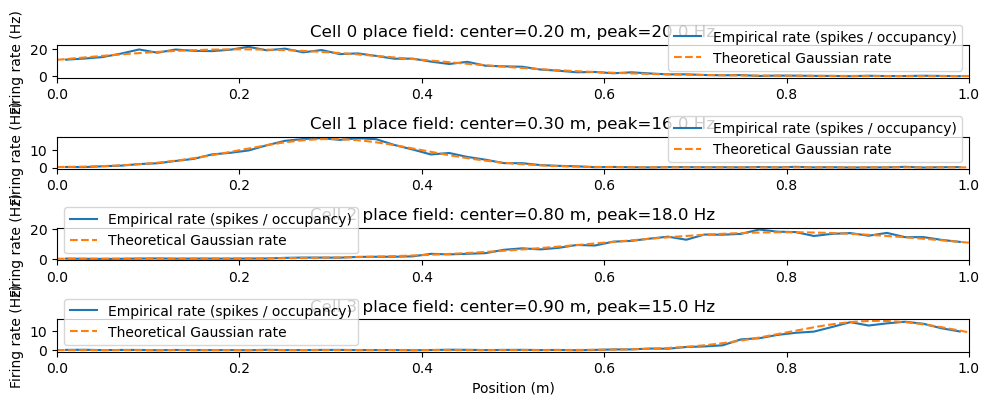

In [11]:
# Empirical rate maps vs theoretical
plt.figure(figsize=(10, 4))
for i in range(n_neurons):
    plt.subplot(n_neurons, 1, i+1)
    plt.plot(bin_centers, empirical_rate_maps[i], label='Empirical rate (spikes / occupancy)')
    plt.plot(x, theoretical_rates[i], label='Theoretical Gaussian rate', linestyle='--')
    plt.ylabel('Firing rate (Hz)')
    plt.title(f'Cell {i} place field: center={centers[i]:.2f} m, peak={peak_rates[i]} Hz')
    plt.xlim(0, track_length)
    plt.legend()
plt.xlabel('Position (m)')
plt.tight_layout()
plt.show()

### Part 2: Add 96 noise neurons with random firing independent of position

In [12]:
# parameters
n_noise = 96
noise_rates = np.random.uniform(1, 5, size=n_noise)  # Hz, random per neuron

# expand rates to all timesteps
noise_rates_matrix = noise_rates[:, None] * np.ones((n_noise, n_steps))

# simulate spikes: Bernoulli draws
rng = np.random.default_rng(456)
noise_spikes = rng.random(size=(n_noise, n_steps)) < (noise_rates_matrix * dt)

### Part 3: join spikes from place cells and random noise in a single matrix

In [24]:
# join spikes in a single matrix, where number of rows = number of cells and number of columns = number of samples

all_spikes = np.vstack([spikes, noise_spikes])


In [25]:
# Define function for ratemap of neural activity across positions on the linear track

def plot_firing_rate_heatmap(spikes, positions, times, n_bins=50, smooth_sigma=1.0):
    """
    Plot firing rate heatmap for a population of neurons on a 1D track.
    
    Parameters
    ----------
    spikes : ndarray, shape (n_cells, n_timepoints)
        Binary spike matrix (1 = spike, 0 = no spike).
    positions : ndarray, shape (n_timepoints,)
        Position of the animal at each time point.
    times : ndarray, shape (n_timepoints,)
        Time vector (seconds).
    n_bins : int
        Number of spatial bins along the track.
    smooth_sigma : float
        Standard deviation for Gaussian smoothing (in bins).
    """
    n_cells, n_time = spikes.shape
    
    # Bin positions
    pos_bins = np.linspace(positions.min(), positions.max(), n_bins+1)
    digitized = np.digitize(positions, pos_bins) - 1  # bin indices
    
    # Occupancy (time spent in each position bin)
    dt = np.mean(np.diff(times))
    occupancy = np.zeros(n_bins)
    for b in range(n_bins):
        occupancy[b] = np.sum(digitized == b) * dt
    
    # Avoid divide by zero
    occupancy[occupancy == 0] = np.nan
    
    # Compute firing rate per neuron per position bin
    rate_map = np.zeros((n_cells, n_bins))
    for i in range(n_cells):
        spike_counts, _ = np.histogram(positions[spikes[i] == 1], bins=pos_bins)
        rate_map[i, :] = spike_counts / occupancy
    
    # Smooth along position axis
    if smooth_sigma > 0:
        rate_map = gaussian_filter1d(rate_map, sigma=smooth_sigma, axis=1, mode="nearest")
    
    # Plot heatmap
    plt.figure(figsize=(10, 6))
    plt.imshow(rate_map, aspect="auto", origin="lower", 
               extent=[positions.min(), positions.max(), 0, n_cells],
               cmap="viridis")
    plt.colorbar(label="Firing rate (Hz)")
    plt.xlabel("Position along track (m)")
    plt.ylabel("Neuron index")
    plt.title("Firing rate heatmap")
    plt.show()
    
    return rate_map


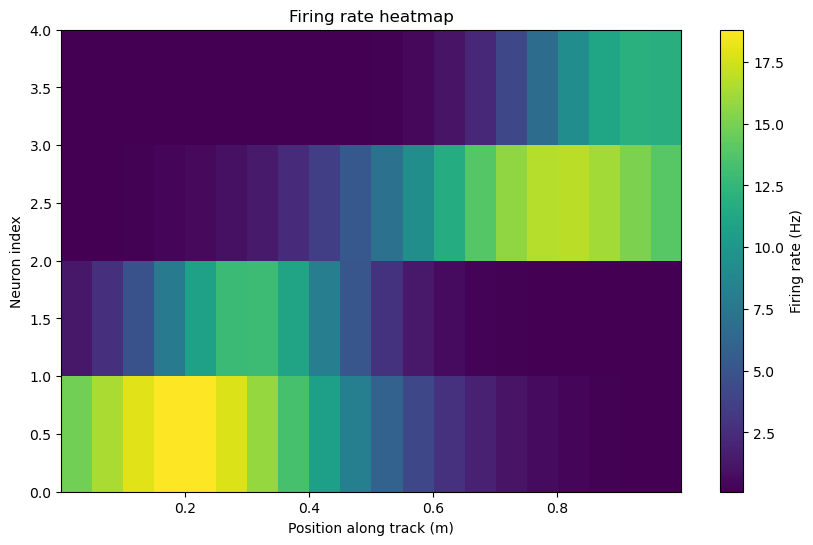

In [21]:
# Plot ratemap of place cells

rate_map = plot_firing_rate_heatmap(spikes, pos, time, n_bins=20, smooth_sigma=1.5)

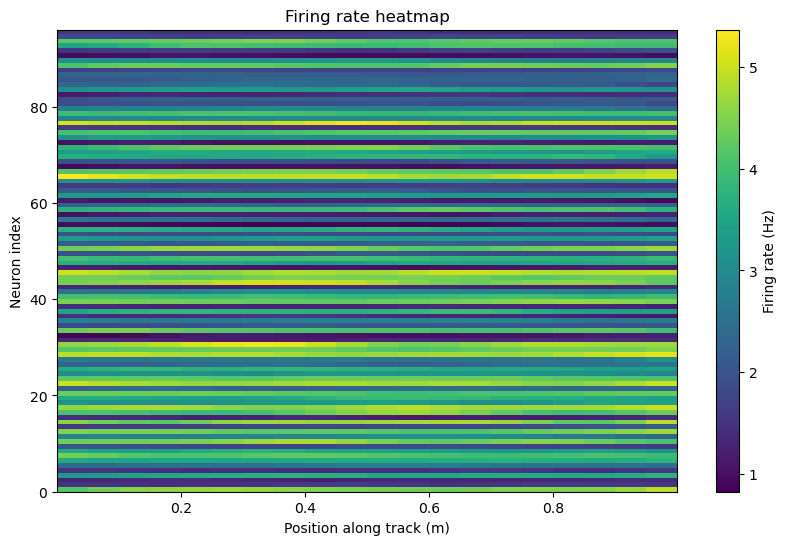

In [22]:
# Plot ratemap of noise cells

rate_map = plot_firing_rate_heatmap(noise_spikes, pos, time, n_bins=20, smooth_sigma=1.5)

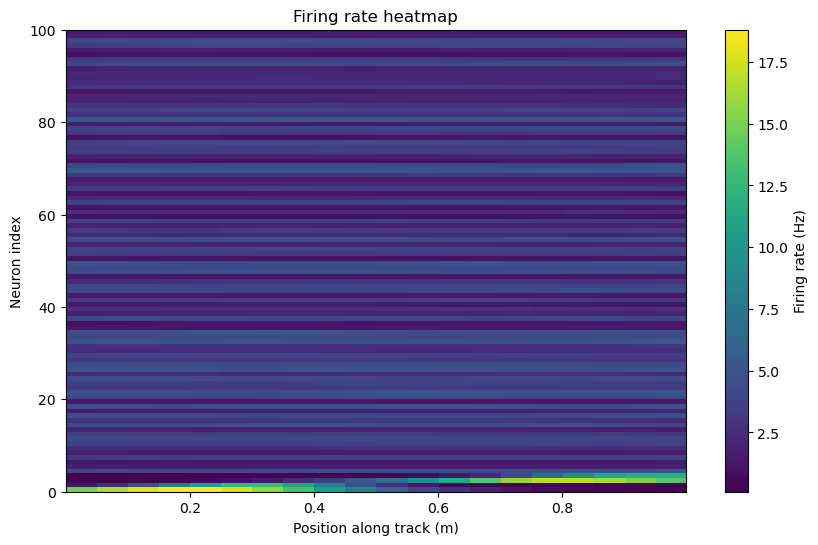

In [26]:
# Plot ratemap of all cells
rate_map = plot_firing_rate_heatmap(all_spikes, pos, time, n_bins=20, smooth_sigma=1.5)

In [ ]:
# Save the resulting spike matrix 

np.save("spike_matrix.npy", all_spikes)
np.save("positions.npy", pos)
np.save("timepoints.npy", time)
